# Example: Finding functionality in software

This notebook covers an example on how to find functionality on software. 


**Prerequisites:**
- You have the surrogate model data of a device. This file contains information from one of our devices, and it typically is named as training_data.pt. If you do not have it, you can request one to Professor Dr. Ir. Wilfred van der Wiel at  w.g.vanderwiel@utwente.nl .
- You have the hardware device on which the model was trained  dipped in one of the National Instruments setups- You have successfully installed brains-py and brains-py tasks. If you do not have access to this, you can still look for a solution on a surrogate model, but you will not be able to validate it on hardware.
- You have completed a previous exercise for determining adequate voltage ranges using iv-curves with brainspy-smg, or you already have the activation electrode ranges that work for the device. For this exercise we will assume, an operating range of activation electrodes of:   
        [[-0.3500,  0.1500],
        [-1.2000,  0.8000],
        [-1.2000,  1.2000],
        [-1.2000,  1.2000],
        [-1.2000,  1.2000],
        [-1.2000,  0.8000],
        [-0.3500,  0.2000]]
- You know which are the optimal data-input and control electrodes for this exercise. For this exercise we will use e1 and e2 as data-input electrodes, and e0, e3-e6 as control electrodes.



    
    

In [85]:
import os
import torch

from IPython.display import Image

import matplotlib.pyplot as plt
from bspytasks.ring.tasks.classifier import plot_inputs


from brainspy.utils.pytorch import TorchUtils
from brainspy.utils.io import load_configs
from bspytasks.ring.data import RingDatasetGenerator # Optional

## 1. Theory

### 1.1 Electrode types in a DNPU

- Activation electrodes: These electrodes receive input voltages (V) that will be used to obtain a non-linear output. The input range for these electrodes typically ranges from -1.2 to 0.7. Outside these outputs the resulting output signal can become noisy [1]. In the image below, activation electrodes range from e0 to e6. These electrodes can be of two types:
    - Data input electrodes: The data from a particular task that wants to be resolved. For example, if the intention was to make the DNPU behave as an XOR boolean gate, two data input electrodes could be used for receiving the combination of all possible input signals (00, 01, 10, and 11) [1]. In the image below, data input electrodes are e2 and e1.
    - Control electrodes: The electrodes that will be used in order to control that the output signals behaves as desired when trying to resolve a particular task. For example, if the intention was to make the DNPU behave as an XOR boolean gate, these electrodes would control the output signal in such a way that it exhibits the outputs 0, 1, 1, 0, for each of the inputs 00, 01, 10, and 11 respectively. In the image below, control electrodes are e0, e3, e4, e5, and e6.
- Readout electrodes: The resulting current (in nA) is measured using these electrodes. In the image below, the readout electrode is e_out

### 1.2 The ring classification problem

In this exercise, we use the tunability properties of single DNPU using a surrogate model, to find the optimal control voltages to make the DNPU behave as a classifier for the ring classification task. This task consists of a set of points located in a two dimensional Cartesian space, where points are distributed in a concentric shape. There is a gap between points that are closer to the concentric point, and those points that are closer to the outskirts of the circle. Each point is labelled as being outside of the gap or inside the gap. The aim of the ring classification problem is to separate these two classes of labels.

The two dimensional input space in the cartesian space, is represented with values between -1 and 1. These values are translated to the full range of the data input electrodes with a linear transformation. We select two electrodes as data-input electrodes, in this case, electrodes e1 and e2. Electrodes e0, e3-e6 are selected as control electrodes. e_out is selected as readout electrode, as the device will only have a single output. The linear transformation is performed automatically by brains-py. 

For more information, we refer to the following paper: 
[1] Ruiz-Euler, H. C., Alegre-Ibarra, U., van de Ven, B., Broersma, H., Bobbert, P. A., & van der Wiel, W. G. (2021). Dopant network processing units: towards efficient neural network emulators with high-capacity nanoelectronic nodes. Neuromorphic Computing and Engineering, 1(2), 024002.

# 2. Creating a dataset (Optional)

There are two options for running the ring task. The first option enables to generate a new dataset with similar characteristics each time the experiment is run. The second option enables to load the data from a directory, in order to execute several experiments on the exact same dataset. The following step shows how to create your own dataset.

In [86]:
if not os.path.exists(os.path.join('tmp','ring')):
    os.makedirs(os.path.join('tmp','ring'))

In [87]:
sample_no = 1500 # Number of samples that the dataset will contain
gap = 0.9 # Gap space for the separation between classes, 
            # in a scale from -1 to 1

In [88]:
RingDatasetGenerator(sample_no, gap, save_dir=os.path.join('tmp','ring'))

The code generated a new file in the folder 3.finding_functionality

In [89]:
os.listdir(os.path.join('tmp','ring'))

['input_data_gap_0.9']

We can load the data that was just generated:

In [90]:
# This line creates a path with the correct / or \ lines, depending on 
# your operating system

data_dir = os.path.join('tmp','ring','input_data_gap_'+str(gap))

ring_data = torch.load(data_dir, map_location=torch.device('cpu'))

list(ring_data)

['inputs', 'targets', 'gap']

And have a look at it:

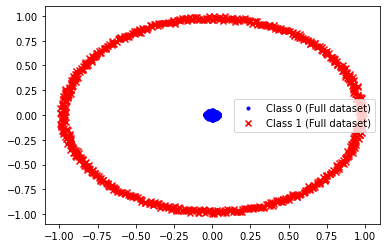

In [91]:
plot_inputs(ring_data,'Full dataset')
plt.legend()
plt.show()

## 3. Configurations for the exercise

The configurations for brains-py are used in yaml format. This formats allows to easily store/read all needed configurations in a file, as well as loading them as a configuration file. 

In [92]:
configs = {
    #This variable specifies the number of attempts that will use in order to try to find a particular gate on the DNPU.
    'results_dir': 'tmp', # It determines where the results of the experiments will be saved. 
}

For this exercise, there is a need to create some configurations to load the dataset that we just created.

In [93]:
data = {
    'load' : data_dir, # Whether to load the ring data from a given directory or not 
    # If load is false, it generates a new dataset. If load is a path to the data, it loads it to the data
    #In this case, corrsig_fit will be used, which uses pearsons correlation and a sigmoid function to determine the fitness.

    'split_percentages' : [0.6,0.2,0.2], # The data is divided into training, validation and test datasets respectively

    'batch_size': 512, # Number of samples from the dataset that will be loaded at a time.

    'worker_no': 0, # How many subprocesses to use for data loading. 0 means that the data 
                   # will be loaded in the main process. (default: 0). Good practice 4 per GPU.
                   
    'pin_memory': True # If True, the data loader will copy Tensors into CUDA pinned memory before
                       # returning them. If your data elements are a custom type, or your collate_fn 
                       # returns a batch that is a custom type.
}

configs['data'] = data

Alternatively, you can set the configurations as follows, to generate a new dataset each time it is run. They have been commented out, because this example only covers data generated on your own. Feel free to play around with it.

In [94]:
# data = {
#     'gap' : 0.5, # Gap space for the separation between classes, 
#                  # in a scale from -1 to 1
#     'sample_no': 5000, # Number of samples that the dataset will contain
#     'load' : False,
#     'load' : data_dir, # Whether to load the ring data from a given directory or not 
#     # If load is false, it generates a new dataset. If load is a path to the data, it loads it to the data
#     #In this case, corrsig_fit will be used, which uses pearsons correlation and a sigmoid function to determine the fitness.
#     'split_percentages' : [0.6,0.2,0.2], # The data is divided into training, validation and test datasets respectively
#     'batch_size': 512, # Number of samples from the dataset that will be loaded at a time.
#     'worker_no': 0, # How many subprocesses to use for data loading. 0 means that the data 
#                    # will be loaded in the main process. (default: 0). Good practice 4 per GPU.
#     'pin_memory': True # If True, the data loader will copy Tensors into CUDA pinned memory before
#                        # returning them. If your data elements are a custom type, or your collate_fn 
#                        # returns a batch that is a custom type.
# }
# 
# configs['data'] = data

For this exercise the gradient descent will be used along with a surrogate model. The configurations can be set as follows:

In [47]:
algorithm_configs = {
    'type' : 'gradient', # Type of algorithm. It can either be 'genetic' or 'gradient'

    'criterion' : 'fisher', # What type of fitness function will be used for training. 

    #In this case, negative fisher will be used, to maximise separability between classes.
    'epochs' : 500, # Number of generations that will be used for the algorithm. (Number of loops)

    'learning_rate': 0.001, # Step size at each iteration while moving toward the minimum of the loss function
    'optimizer': "adam", # Optimisation algorithm to be used. 
                        # In this case, Adam (https://arxiv.org/abs/1412.6980)
                        
    'constraint_control_voltages': "regul", # regul or clip
    'return_best_model': True
}

configs['algorithm'] = algorithm_configs

Note that it can only be ensured that the model will behave as intended, while maintaining itself within the activation electrode ranges with which the surrogate model was created. In order to ensure that the optimisation does not go outside these ranges, there are two different modes:
 - 'regul': Applies a regularisation value to the result of the loss whenever the control voltage values are outside the voltage ranges with which they were trained.
 - 'clip': Applies a clipping to the control voltages, whenver they are outside the voltage ranges with which they were trained.

In order to train the ring classification problem, the negative fisher function was selected. This criterion maximises the separability between two classes. However, it is difficult to know in advance at which output current levels will be the found solution. In order to have more information about the quality of the output, a simple perceptron, consisting of a linear layer and a sigmoid is trained on the normalised output. The perceptrons linear layer, will determine a threshold at which an output can be considered either 0 or 1. By comparing the final result 0 or 1 against the original label, the information of the accuracy can be calculated. This is done by counting the number of correctly classified inputs, against the total number of inputs.  

In [48]:
perceptron_configs = {
    'epochs' : 600, # Number of epochs used to train the perceptron classifier

    'learning_rate': 0.01, # Learning rate at which the perceptron classifier will be trained
    
    'batch_size': 512 # Batch size at which the perceptron classifier will be trained
}
configs['accuracy'] = perceptron_configs
# configs["return_best_model"] = True

The last part of the configurations are related to the drivers used for a particular setup. It is important to ensure that electrodes are connected to the DNPU correctly, you can double check the last schematic with its connections to the corresponing National Instruments device.

In [49]:
processor_configs = {
    "processor_type" : 'simulation', # In this case, we are using a processor for simulation purp

    'model_dir': 'surrogate_model/training_data.pt',

    'input_indices': [2,3],
    
    'waveform': {
        'plateau_length': 1,
        'slope_length': 0
    },
    'electrode_effects':{
        'type' :  'gaussian',
        'variance': 2
    }
}
configs['processor'] = processor_configs

# 4. Creating a custom model

Brains-py allows a very flexible implementation of different simulation circuits by leveraging PyTorch's nn.Module architecture. For this reason, the expected usage of brains-py is by creating a custom nn.Module that suits your needs. For the particular example covered in this notebook, we will be using a direct connection to the hardware device. 

For this, we can almost directly use the class DNPU, which is an instance of a nn.Module of PyTorch. The DNPU class enables to declare control voltages as learnable parameters, and can be integrated with the genetic algorithm in order to find best voltages on hardware. The DNPU class supports to have the same processor acting as if it was many processors in a time-multiplexed manner. However, for this example we would be only using a single DNPU. We will pass the information about the input indices using the configs flag the we added previously, 'input_indices'.

We also want the Processor class to internally contain an instance of HardwareProcessor. This is done by specifying the processor_type flag in the configs of the processor. Note that for simulation instances of the processor, an info dictionary is also required. We can directly initialise a such an instance of processor by just calling Processor(configs). 

More information about the Processor structure, and how it is implemented in brains-py can be found in https://github.com/BraiNEdarwin/brains-py/wiki/B.-Package-description

More information about the info dictionary can be found in the wiki of brainspy-smg. 

In [50]:
from brainspy.processors.dnpu import DNPU
from brainspy.processors.processor import Processor
from brainspy.utils.pytorch import TorchUtils 

class DefaultCustomModel(DNPU):
    
    def __init__(self, configs):
        # For this simple example, we just need a simple instance of a DNPU, but where input indices are defined 
        # already in the configs. The input indices are the electrodes that will be receiving the two dimensional
        # data for the boolean gates task. 
        
        # In order to load a surrogate model, the data can be extracted from the training_data.pt
        # generated during the training with the smg. 
        
        model_data = torch.load(configs['model_dir'],
                                map_location=TorchUtils.get_device())
        
        # This data contains the info dictionary, required to know, among other things,
        # the structure used in the neural network for training the device 
        # (In this example 5 layers of 90 nodes each, with ReLU as activation function).
        # Additionally, this file contains the model_state_dict, which
        # contains the weight values for the trained neural network simulating the DNPU.
        
        # The following line, is very similar to that used for initialising the hardware in notebook
        # number 2. But it now contains the info dictionary and the model_state_dict keys.
        super(DefaultCustomModel, self).__init__(Processor(configs, model_data['info'], model_data['model_state_dict']), [configs['input_indices']])
        
        # Additonally, we know that the data that we will be receiving for our example will be in a range from -1 to 1.
        # brains-py supports automatic transformation of the inputs, to the voltage ranges of the selected input indices.
        # This is done with the following line:
        self.add_input_transform([-1, 1])

# 5. Finding a solution

In [51]:
from brainspy.utils import manager

criterion = manager.get_criterion(configs["algorithm"]['criterion'])
algorithm = manager.get_algorithm(configs["algorithm"]['type'])

In [52]:
from bspytasks.ring.tasks.classifier import get_ring_data

dataloaders = get_ring_data(configs)

In [53]:
from bspytasks.ring.tasks.classifier import ring_task

results, trained_model, results_dir = ring_task(configs, dataloaders, DefaultCustomModel, criterion, algorithm)

c:\users\unai\documents\programming\brains-py\brainspy\processors\simulation\noise\noise.py:97: UserWarning: No noise is being simulated for the model.
  warnings.warn("No noise is being simulated for the model.")
c:\users\unai\documents\programming\brains-py\brainspy\utils\waveform.py:78: UserWarning: Slope Length is 0
  warnings.warn("Slope Length is 0")
Training Loss: -1.497903.. Validation Loss: -1.408541..  Saving model ...:   0%|               | 0/500 [00:00<?, ?it/s]

GAP: 0.9


Training Loss: -5.777051.. Validation Loss: -5.238837.. : 100%|██████████████████████| 500/500 [00:26<00:00, 18.77it/s]
Training perceptron: Epoch: 599  Accuracy 98.11111111111111, running loss: 0.040977730883492366: 100%|█| 600/600 [00:11


Train accuracy: 98.11111450195312
Validation accuracy: 97.0
Test accuracy: 96.0


The classifier produces a resutls dictionary, containing all the information produced while trianing, the raw trained model, and the directory where the resutls dictionary has been saved.

In [54]:
results.keys()

dict_keys(['gap', 'train_results', 'dev_results', 'test_results'])

In [55]:
results['train_results'].keys()

dict_keys(['performance', 'inputs', 'inputs_wvfrm', 'targets', 'targets_wvfrm', 'best_output', 'accuracy', 'correlation', 'performance_history'])

 - performance 
 - inputs
 - targets
 - best_output
 - accuracy
 - correlation
 - performance_history

In [56]:
trained_model.get_control_voltages()

tensor([[-0.3054,  0.5435,  0.4953, -0.4861, -0.2277]], device='cuda:0')

In [57]:
results.keys()

dict_keys(['gap', 'train_results', 'dev_results', 'test_results'])

The information produced during the training of the classifier is stored in the following directory: 

In [58]:
results_dir

'tmp\\ring_classification_gap_0.9_2022_08_23_164502'

The information that running the classifier produces is divided into two main folders: results and reproducibility.

In [59]:
os.listdir(results_dir)

['reproducibility', 'results']

# 6. Analysing results

In [60]:
os.listdir(os.path.join(results_dir,'results') )

['dev_accuracy.jpg',
 'Dev_output.png',
 'input.png',
 'test_accuracy.jpg',
 'Test_output.png',
 'training_profile.png',
 'train_accuracy.jpg',
 'Train_output.png']

In [61]:
Image(url= os.path.join(os.path.join(results_dir,'results'), "training_profile.png"))

In [62]:
Image(url= os.path.join(os.path.join(results_dir,'results'), "train_accuracy.jpg"))

In [63]:
Image(url= os.path.join(os.path.join(results_dir,'results'), "train_output.png"))

Similar images are produced for the validation (dev), and test datasets. These can be found and plotted in the same way.

# 7. Reproducing results

The files needed for reproducing the results are stored in the reproducibility directory. This includes a raw image of the best model and the model in the last training epoch. These are raw models that can be loaded directly and contain an instance of a class. This way of loading devices is faster (only requires torch.load('best_model_raw.pt'), but not officially recommended by pytorch, as it requires a copy of the code for the model delcaration (in this case, DefaultCustomModel). If you experience problems loading data in this way, you can also load it in the recommended way, using best_training_data.pickle, that contains the model_state_dict with all the learnable parameters for the classifier. In addition to these files, the original configurations of the exercise are available as 'configs.yaml', and the results for training the exercise are stored as 'results.pickle'.

In [64]:
os.listdir(os.path.join(results_dir,'reproducibility') )

['best_model_raw.pt',
 'best_training_data.pickle',
 'configs.yaml',
 'model_raw.pt',
 'results.pickle',
 'training_data.pickle']

You can load the exact same configurations as those used in the exercise by executing the following line:

In [65]:
reloaded_configs = load_configs(os.path.join(results_dir,'reproducibility','configs.yaml'))

Below, you can find an example on how a model can be loaded in the recommended way. Note that after loading the state dictionary, the control voltages are the same as those found in the solution. More information about loading models in pytorch can be found here: https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html#:~:text=What%20is%20a%20state_dict%20in%20PyTorch%20In%20PyTorch%2C,that%20maps%20each%20layer%20to%20its%20parameter%20tensor.

In [66]:
training_data = torch.load(os.path.join(results_dir,'reproducibility','best_training_data.pickle'), map_location=TorchUtils.get_device())

In [67]:
training_data['model_state_dict']['control_voltages']

tensor([[-0.3054,  0.5435,  0.4953, -0.4861, -0.2277]], device='cuda:0')

In [68]:
reloaded_model = DefaultCustomModel(reloaded_configs['processor'])
# The model is initialised with random control voltages
reloaded_model.get_control_voltages()

c:\users\unai\documents\programming\brains-py\brainspy\processors\simulation\noise\noise.py:97: UserWarning: No noise is being simulated for the model.
  warnings.warn("No noise is being simulated for the model.")
c:\users\unai\documents\programming\brains-py\brainspy\utils\waveform.py:78: UserWarning: Slope Length is 0
  warnings.warn("Slope Length is 0")


tensor([[ 0.0919, -0.3405, -0.9884,  0.4016,  0.1767]])

In [69]:
reloaded_model.load_state_dict(training_data['model_state_dict'])
# The model is loaded with the correct control voltages from the best solution found
reloaded_model.get_control_voltages()

tensor([[-0.3054,  0.5435,  0.4953, -0.4861, -0.2277]])

The same results as those returned by the trainer can also be loaded again:

In [70]:
loaded_results = torch.load(os.path.join(results_dir,'reproducibility','results.pickle'), map_location=TorchUtils.get_device())

In [71]:
loaded_results.keys()

dict_keys(['gap', 'train_results', 'dev_results', 'test_results'])

# 8. Validating results in hardware

**Read this carefully before continuing with the notebook**

This notebook has created to be run on BRAINS computer. The computer should be connected to the National Instruments setup consisting of a chassis and several modules. The setup should be connected to a hardware device. If you not running this test in a BRAINS computer, you should change the configurations according to how your national instruments are connected. The names of the national instruments modules can be checked on the NI MAX tool. The following values should at least be updated when in a new computer with different modules (you can jump directly to the following cell):

* "trigger_source": "cDAQ1/segment1", # This particular one makes reference to the NI Chassis allocated at cDAQ1, and the trigger source segment1. Find the different triggers you can use with your own NI module in the NI MAX tools. 
* "activation_instrument": "cDAQ1Mod3", # This refers to the module of the chassis that will be used for sending inputs to the device, in this case Mod3
* "activation channels": [0,1,2,3,4,5,6], # Typically the 7 activation electrode inputs, as connected to the national instruments setup 
* "readout_instrument": "cDAQ1Mod4", # This refers to the module of the chassis that will be used for readoung outputs from the device, in this case Mod4
* "readout_channels": [0] # Typically the single readout electrode of the device

In [72]:
import matplotlib.pyplot as plt

In [73]:
# HARDWARE_MODE
TRIGGER_SOURCE = 'cDAQ2'
ACTIVATION_INSTRUMENT = 'cDAQ2Mod3'
ACTIVATION_CHANNELS = [14, 7, 13, 8, 10, 11, 12] #[0,2,5,3,1,6,4]
READOUT_INSTRUMENT = 'cDAQ2Mod8'
READOUT_CHANNELS = [2]

In [78]:
hw_processor_configs = {
    "processor_type" : 'cdaq_to_cdaq', # There are four different processor types: 'simulation', 'cdaq_to_cdaq', 'cdaq_to_nidaq', 'simulation_debug'. The first 
    'input_indices': [2,3], # It specifies what indices will be taken as data input. These correspond to the indices of the activation channels inside the instruments setup configuration. 
    'waveform': { # The waveform determines the number of points that will be used to represent a single point. More information about waveforms can be found at Section 5.1 Waveforms: https://github.com/BraiNEdarwin/brains-py/wiki/A.-Introduction
        'plateau_length' : 50, 
        'slope_length' : 50
    }
}

In [79]:
driver_configs = {
        'inverted_output': True, # Whether if the op-amp circuit to amplify the output of the DNPU applies an inversion or not.
        'amplification': [28], # Indicates the amplification correction factor that will be applied to obtain the real current measurement from the setup. More information about this can be found in Section 5.3 of the introduction of brains-py wiki: https://github.com/BraiNEdarwin/brains-py/wiki/A.-Introduction
        'instruments_setup':{ 
            'multiple_devices': False, # Indicates whether if the setup is using a PCB with multiple devices or not.
            'trigger_source': TRIGGER_SOURCE, # Triggering signal to be sent for reading synchronisation. You can check for this signal for your setup on the NIMax app.
            'average_io_point_difference': True, # If number of points read from the device is different from the number of points written to the device due to a difference in their
                                                # sampling frequencies, this variable indicates if there should be an averaging so that the input and output have the same length.
            'activation_instrument': ACTIVATION_INSTRUMENT, # Main module used for sending voltage signals to the DNPU 
            'activation_sampling_frequency': 1000, # Number of samples that will be written to the DNPU in one second.
            'activation_channels': [6,0,1,5,2,4,3], # Channels of the module that will be used for sending signals the device. 
            'activation_voltage_ranges': # Maximum minimum and maximum voltage ranges that will be allowed to be sent to the DNPU, per electrode. Dimensions (Electrode_no, 2)
              [ [-0.3500,  0.1500],
                [-1.2000,  0.8000],
                [-1.2000,  1.2000],
                [-1.2000,  1.2000],
                [-1.2000,  1.2000],
                [-1.2000,  0.8000],
                [-0.3500,  0.2000]
              ],
            'readout_instrument': READOUT_INSTRUMENT, # Main module used for receiving voltage signals from the DNPU (after the op-amp) 
            'readout_sampling_frequency': 2000, # Number of samples that will be read from the DNPU in one second
            'readout_channels': [0], # Channels of the module that will be used for reading signals from the device. 
            'activation_channel_mask': [1, 1, 1, 1, 1, 1, 1] # Whether if all the channels connected to the device electrodes would be used or not. 1 for enabling its use, 0 for disabling it. When disabled, the channels will not be declared.
        }
    
}
hw_processor_configs['driver'] = driver_configs

Once the configurations for the hardware are ready, we need to fetch the original info dictionary

In [80]:
reloaded_model.hw_eval(hw_processor_configs)

DAC sampling frequency: 1000
ADC sampling frequency: 2000
DAC/ADC point difference: 2
Max ramping time: 0.1 seconds. 


In [81]:
inputs = loaded_results['train_results']['inputs']
model_predictions = loaded_results['train_results']['best_output']

In [82]:
hw_predictions = reloaded_model(inputs)

In [83]:
hw_predictions.shape

torch.Size([900, 1])

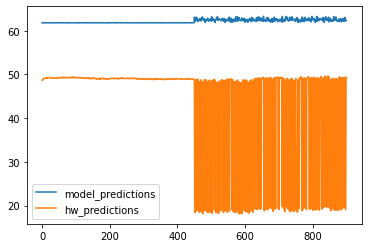

In [84]:
plt.plot(TorchUtils.to_numpy(model_predictions), label='model_predictions')
plt.plot(TorchUtils.to_numpy(hw_predictions), label='hw_predictions')
plt.legend()
plt.show()

In [70]:
reloaded_model.close()

In [45]:
from bspysmg.utils.consistency import consistency_check
from brainspy.processors.processor import Processor
data = torch.load('surrogate_model/training_data.pt')
print(data.keys())
print(data['info'])
configs['processor']['electrode_info'] = {}
configs['processor']['electrode_info']['amplification'] = [41]
p = Processor(configs['processor'], info=data['info'], model_state_dict=data['model_state_dict'])
p = TorchUtils.format(p)
data_dir_t = "C:/Users/Unai/Documents/programming/brainspy-examples/tmp/smg/jupyter_notebook_examples_2022_08_16_171320"


dict_keys(['epoch', 'model_state_dict', 'info', 'optimizer_state_dict', 'train_losses', 'val_losses', 'min_val_loss', 'test_loss'])
{'model_structure': {'hidden_sizes': [90, 90, 90, 90, 90], 'D_in': 7, 'D_out': 1, 'batch_norm': False, 'activation': 'relu'}, 'electrode_info': {'electrode_no': 8, 'activation_electrodes': {'electrode_no': 7, 'voltage_ranges': array([[-0.35      ,  0.15      ],
       [-1.2       ,  0.8       ],
       [-1.2       ,  1.2       ],
       [-1.2       ,  1.2       ],
       [-1.2       ,  1.2       ],
       [-1.2       ,  0.8       ],
       [-0.35000002,  0.2       ]], dtype=float32)}, 'output_electrodes': {'electrode_no': 1, 'amplification': [41], 'clipping_value': [-164, 164]}}, 'training_configs': {'results_base_dir': 'tmp/smg\\jupyter_notebook_examples_2022_08_16_171320', 'hyperparameters': {'epochs': 100, 'learning_rate': 0.001}, 'data': {'dataset_paths': ['tmp/smg\\jupyter_notebook_examples_2022_08_16_171320\\postprocessed_data.npz'], 'split_percentag

c:\users\unai\documents\programming\brains-py\brainspy\processors\simulation\noise\noise.py:97: UserWarning: No noise is being simulated for the model.
  warnings.warn("No noise is being simulated for the model.")
c:\users\unai\documents\programming\brains-py\brainspy\utils\waveform.py:78: UserWarning: Slope Length is 0
  warnings.warn("Slope Length is 0")


In [46]:
consistency_check(data_dir_t, repetitions=10, model=p)

DAC sampling frequency: 5000
ADC sampling frequency: 10000
DAC/ADC point difference: 2
Max ramping time: 0.1 seconds. 
Start batching...
There was an error writing to the activation task: activation_task_2022_08_23_141043_333828
The specified resource is reserved. The operation could not be completed as specified.
Task Name: activation_task_2022_08_23_141043_333828

Status Code: -50103


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x29392333ee0>


Nothing could be read. Stopping program
Interruption/Termination signal received. Waiting for the reader to finish.
Closing nidaqmx tasks


SystemExit: 0

C:\Users\Unai\anaconda3\envs\bspy\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
